<a href="https://colab.research.google.com/github/BubuDavid/Fundamentos-de-Procesamiento-Digital-de-Imagenes/blob/main/tareas/tarea8/Tarea8_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 8
Puede ver el código original en el siguiente link: https://colab.research.google.com/drive/1V0mnnHOtT68WHglBL_oYfsc4GcAfNO2H?usp=sharing

# Funciones auxiliares

En la siguiente celda, se podrán encontrar funciones que son útiles al momento de estar trabajando en esta materia, cada función tiene su propia descripción y uso. Ya tengo un documento plantilla para copiar y pegar estas funciones por lo que puede llegar el caso de que no usemos alguna de las funcioens que estén aquí.

In [36]:
# Este script tiene algunas funciones que son útiles tanto en tareas como en apuntes de la clase
# Importando librerías
import cv2 # Para manejar imágenes
import matplotlib.pyplot as plt # Para visualizar las imágenes (Se puede hacer de otra manera con una librería de google pero meh, este está bueno)
import numpy as np # Para operar matrices de manera sencilla
from scipy.ndimage import correlate, convolve


##### Operaciones iniciales con imágenes (Leer, mostrar, mostrar histogramas, etc.) #####
# Desplegar histogramas
# Leer imagen en escala de grises
def read_img(img_name, **kwarg):
	"""Lee imágenes con ayuda de opencv y la muestra

	Args:
		img_name (str): Nombre del path donde se encuentra la imagen

	Returns:
		np.array: Retorna la imagen que se leyó después de mostrarla
	"""
	img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
	show_img(img, is_gray = True, info = True, **kwarg)
	return img

# Mostrar imágenes
def show_img(img, size = (7, 7), is_gray = True, info = False):
	"""Muestra una imagen con tamaño específico.

	Args:
		img (np.array): Imagen que se desea mostrar
		size (tuple, optional): Tamaño relativo de la imagen. Recomendado (7, 7).
		is_gray (bool, optional): Si la imagen es en blanco y negro activar. Recomendado True.
		info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
	"""
	fig, axs = plt.subplots(figsize=size)
	if is_gray:
		axs.imshow(img, cmap='gray', vmin=0, vmax=255)
	else:
		axs.imshow(img)
	axs.axis("off")

	if info:
		print(f"Imagen de dimensiones: {img.shape}, con un total de {img.size} pixeles")

# Mostrar varias imágenes
def show_imgs_row(imgs, size = (7,7), is_gray = True, info = False, titles = None):
	"""Muestra imágenes en una sola fila (se recomiendan menos de 5 imágenes para mejor visibilidad)

	Args:
		imgs (List[np.array]): Lista de imágenes a desplegar
		size (tuple, optional): Tamaño relativo de cada imagen a desplegar. Recomendado (7,7).
		is_gray (bool, optional): Si es o no blanco y negro. Recomendado True.
		info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
		titles (_type_, optional): Lista de títulos para la imagen. Recomendado None.
	"""
	schema = (1, len(imgs))
	options = {}
	if is_gray:
		options["cmap"] = "gray"
		options["vmin"] = 0
		options["vmax"] = 255

	fig, axs = plt.subplots(*schema, figsize=size)

	for index in range(len(imgs)):
		axs[index].imshow(imgs[index], **options)
		axs[index].axis("off")
		if titles:
			axs[index].set_title(titles[index])

def show_histograms(imgs, bin_value = 20, colors = [None, "g"], titles = ["Normal", "No normal"], normalized = True, edgecolor = "black", cumulative = False, size = (15, 5), **kwargs):
	"""Muestra y regresa histogramas de las imágenes que le pases.

	Args:
		imgs (List[np.array]): Lista de imágenes a calcular sus histograms
		bin_value (int, optional): Rango de los bins en nuestros plots. Recomendado 20.
		colors (list, optional): Lista de colores para los histogramas. Recomendado [None, "g"].
		titles (list, optional): Lista de títulos para los histogramas. Recomendado ["Normal", "No normal"].
		normalized (bool, optional): Dicta si los histogramas están normalizados o no. Recomendado True.
		edgecolor (str, optional): El color del borde de cada bin, también se puede dejar en None si no quieres borde. Recomendado "black".
		cumulative (bool, optional): Esto indica si los histogramas son acumultivos o no. Recomendado False.
		size (tuple, optional): Tamaño de las gráficas. Recomendado (15, 5).

	Returns:
		hist: Lista con los histogramas calculados.
		bins: Lista con los bins calculados aunque usualmente son iguales todos.
	"""
	if type(imgs) != list:
		imgs = [imgs]
	if type(titles) != list:
		titles = [titles]
	
	flattens = np.array(list(map(lambda img: img.ravel(), imgs)))
	bins = np.array([np.linspace(0, 255, bin_value) for i in range(len(imgs))])
	hists = []
	fig, ax = plt.subplots(1, len(imgs), figsize = size)
	
	if len(imgs) == 1:
		img, b = imgs[0], bins[0]
		
		hist, b = np.histogram(img, bins = b)
		if normalized:
			hist = hist / img.size
		if cumulative:
			hist = np.cumsum(hist)
		ax.hist(b[:-1], b, weights = hist, color = colors[0], edgecolor = edgecolor, **kwargs)
		ax.set_title(titles[0])
		return hist, b
	else:
		for index in range(len(flattens)):
			img, b = imgs[index], bins[index]
			hist, b = np.histogram(img, bins = b)
			if normalized:
				hist = hist / img.size
			if cumulative:
				hist = np.cumsum(hist)
			
			ax[index].hist(b[:-1], b, weights = hist, color = colors[index], edgecolor = edgecolor, **kwargs)
			ax[index].set_title(titles[index])
			hists.append(hist)
	return hists, bins

###### Transformaciones generales sobre imágenes ######
# Creditos: http://learnwebgl.brown37.net/08_projections/projections_mapping.html
def img_scale(img, minf, maxf):
    a, b = np.min(img), np.max(img)
    scale = (maxf - minf)/(b - a)
    offset = -a*scale + minf
    rescaled = img*scale + offset
    return rescaled

###### Transformaciones de intensidades de imágenes ######

# Binarize images

# Transformación Negativa
def imcomplement(img):
	"""Función para generar el negativo de una imagen en blanco y negro

	Args:
		img (np.array): Imagen a negativizar

	Returns:
		negative_img: Imagen negativa
	"""
	return np.abs(255 - img)

# Genera imagenes binarias
def binarize(img, max_val):
	"""Genera imágenes binarias a partir de un cierto max_val

	Args:
		img (np.array): Imagen a binarizar
		max_val (int): Límite en el cual se considera 1 o 0

	Returns:
		binarized_img: Imagen binaria obtenida
	"""
	return (img >= max_val) * 255

# Credits: https://www.nzfaruqui.com/contrast-stretching-in-image-processing-using-matlab/
def imadjust(img,lim_in = [0, 1], lim_out = [0, 1], gamma=1, plot = False):
	"""Imagen que ajusta a un rango determinado con una gamma correction definida (Hace lo mismo que la función de matlab)

	Args:
		img (np.array): Imagen a transformar
		lim_in (list, optional): Limites de la imagen de input. Defaults to [0, 1].
		lim_out (list, optional): Limites de la imagen de output. Defaults to [0, 1].
		gamma (int, optional): Factor gamma de la función. Defaults to 1.
		plot (bool, optional): Si se desea graficar le función gamma. Defaults to False.

	Returns:
		adjusted_img: Imagen ajustada
	"""
	c, d = lim_in
	a, b = lim_out
	# Normalización para que esto funcione
	img_cp = img.copy()
	if np.max(img_cp) > 1:
		img_cp = img_cp / np.max(img_cp)

	# Básicamente esto es lo que hace imadjust ☝ ver la fuente para mayor información
	adj = (((img_cp - a) / (b - a)) ** gamma) * (d - c) + c
	# Regresando a las dimensiones originales
	adj = np.int64(adj / np.max(adj) * 255)

	# Grafica la función
	if plot:
		x = np.linspace(0, 1, 1000)
		y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
		plt.plot(x,y, c='g')
		plt.title(f'Función adjust con a={a}, b={b}, c={c}, d={d}, gamma={gamma}')
	return adj

def equalizeHist(img):
	"""Función que ecualiza el histograma de una imagen

	Args:
		img (np.array): Imagen a ser ecualizada

	Returns:
		equ_img: Imagen Ecualizada
	"""
	return cv2.equalizeHist(img)

###### fspecials ######
def fspecial_gauss(kernel_shape=(3,3), sigma=0.5):
    m,n = [(ss-1.)/2. for ss in kernel_shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def fspecial_laplacian(alpha = 1/5):
    alpha = max(0,min(alpha,1))
    h1 = alpha/(alpha+1)
    h2 = (1-alpha)/(alpha+1)
    h = np.array([[h1, h2, h1], [h2, -4/(alpha + 1), h2], [h1, h2, h1]])
    return h

def fspecial_average(shape):
	h = np.ones(shape)/np.prod(shape)
	return h

# Problemas y resolución

## 1. (2 puntos) Realice una función que se llame IGBoost, que reciba una imagen, el tamaño de kernel, la sigma y un parámetro de combinación, con estos datos la función debe realizar el filtrado highboost, a diferencia de lo visto en clase, esta función hará un suavizado con un filtro Gaussiano en vez de una suavización con kernel de caja. El parámetro de combinación se ocupará para pesar la suma de la imagen suavizada con la imagen original.

In [37]:
# Para esto se tiene que importar cosas
def IGBoost(img, kernel_shape, sigma, comb):

    # Obtener el kernel y filtrar la imagen
    kernel = fspecial_gauss(kernel_shape, sigma)
    g = correlate(img, kernel, mode = 'nearest')

    # Comparando
    mask = img - g
    mask = mask * comb
    return img + mask

## 2. (2 puntos) Realice una función que reciba una imagen y un parámetro de combinación, con estos dos datos la función hará un reforzamiento de bordes usando reforzamiento por Lapaciano; el parámetro que recibe la función pesará la suma de la imagen original con su Laplaciano.

In [38]:
def ref_bord_lap(img, comb):
    kernel = fspecial_laplacian(1)
    g = convolve(img, kernel, mode = 'mirror')

    # Pesando la suma de la imagen
    mask = img - g
    mask = mask * comb
    return img + mask

## 3. (1 punto) Aplique las dos funciones anteriores a la imagen Fig0303(a).tif, encuentre los parámetros apropaidos que perminta que en la imagen se refuerce el tumor (zona hiperintesa de la mamografía). Reporte valores e imágenes tratadas

Imagen de dimensiones: (1164, 984), con un total de 1145376 pixeles


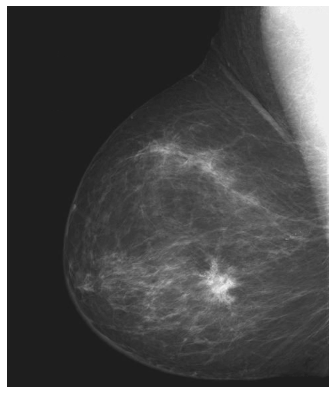

In [39]:
img1 = read_img('Fig0303(a).tif')

In [44]:
# Parametros apropiados
kernel_shape = [51, 51]
comb1 = 4
comb2 = -0.6
sigma = 8

In [45]:
# igboost
ig_boost_img = IGBoost(img1, kernel_shape, sigma, comb1)

In [46]:
# ref_bord_lap
ref_bord_lap_img = ref_bord_lap(img1, comb2)

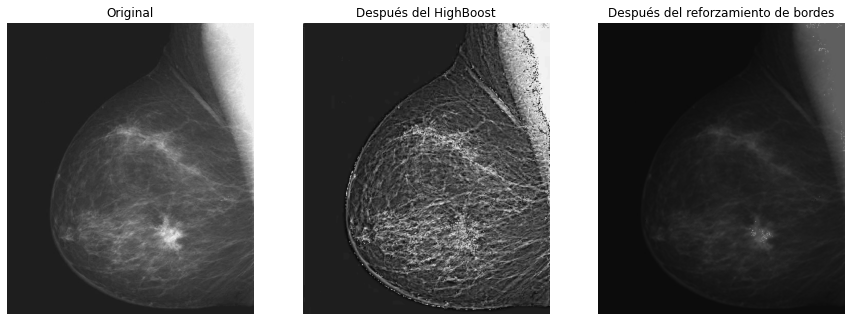

In [47]:
# Mostrando resultados
show_imgs_row(
    [img1, ig_boost_img, ref_bord_lap_img],
    titles = [
        "Original",
        "Después del HighBoost",
        "Después del reforzamiento de bordes"
    ],
    size = (15, 15)
)

## 4. (5 puntos) A la imagen Fig0319Noise.tif aplíquele filtros de caja y gaussianos con distintos parámetros para eliminar el ruido lo más posible y lograr que la imagen recuperada se parezca la imagen Fig0319(a).tif. Muestre los resultados obtenidos y los parámetros utilizados.

Imagen de dimensiones: (915, 948), con un total de 867420 pixeles


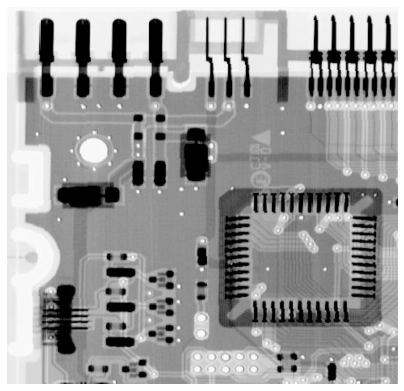

In [52]:
img2 = read_img('Fig0319(a).tif')

Imagen de dimensiones: (915, 948), con un total de 867420 pixeles


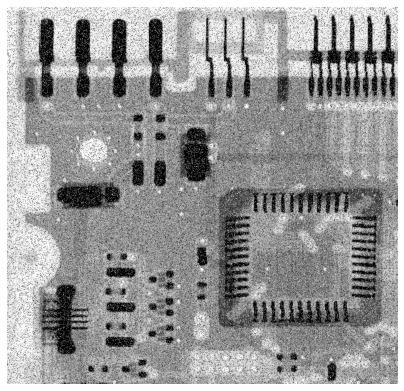

In [53]:
img2_noisy = read_img('Fig0319Noise.tif')

In [54]:
# Definiendo kernels
kernel_caja = fspecial_average((31, 31))
kernel_gaussian = fspecial_gauss((31, 31))

In [55]:
caja_img = convolve(img2_noisy, kernel_caja, mode = 'nearest')
gaussian_img = convolve(img2_noisy, kernel_gaussian, mode = 'nearest')

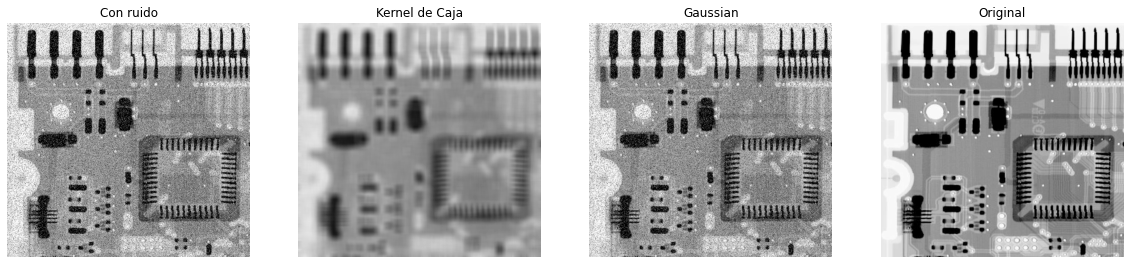

In [61]:
# Mostrando resultados
show_imgs_row(
    [img2_noisy, caja_img, gaussian_img, img2],
    titles = [
        "Con ruido",
        "Kernel de Caja",
        "Gaussian",
        "Original",
    ],
    size = (20, 20)
)

### Ahora haga un filtrado de mediana cambiando parámetros, reporte los valores y el resultado de este filtrado.

In [62]:
# Necesito importar de scipy
from scipy.signal import medfilt2d

In [63]:
# Filtrando por mediana
med_img = medfilt2d(img2_noisy, 9)

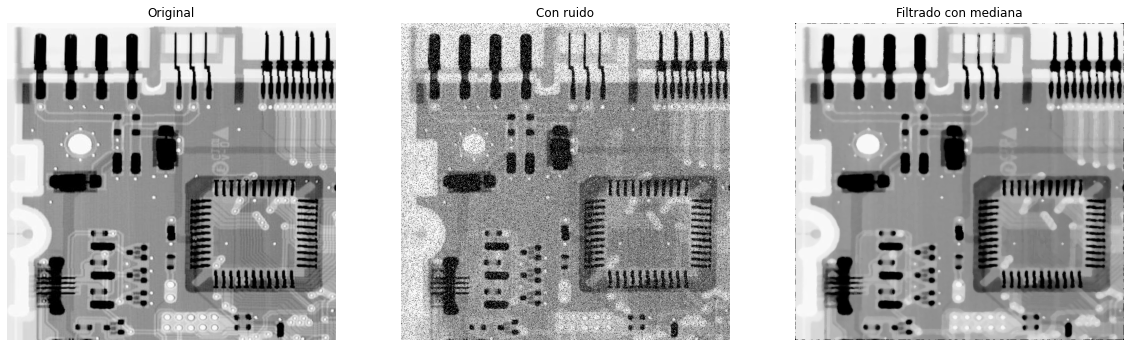

In [64]:
# Mostrando resultados
show_imgs_row(
    [img2, img2_noisy, med_img],
    titles = [
        "Original",
        "Con ruido",
        "Filtrado con mediana"
    ],
    size = (20, 20)
)